# Polygons vs hexgrid? What's the deal?

In [1]:
import requests, zipfile, io, os
from datetime import datetime
import geopandas as gpd
import pandas as pd
from pyrosm import OSM
import matplotlib.pyplot as plt

C:\Users\Mikhail\AppData\Local\Continuum\miniconda3\envs\heatvuln\lib\site-packages\pyrosm\utils\_compat.py:12: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). The tool will work but it runs a bit slower.
  shapely_geos_version, geos_capi_version_string


Let's see...

## Step 1. Download and store the data

_OSM data_

We're downloading an OSM data dump from [Geofabrik](https://download.geofabrik.de/) simply via _requests_. The website says "Geofabrik was created out of the conviction that free geodata created by projects like OpenStreetMap will become increasingly attractive for commercial uses." In this example I'll use data for the Greater London.

In [2]:
%%time
url = 'https://download.geofabrik.de/europe/great-britain/england/greater-london-latest.osm.pbf' # url to the Greater London data
r = requests.get(url)

directory = "data/raw/pois/" # create a directory to store data
if not os.path.exists(directory):
    print(f'Succefully created new directory: {directory}')
    os.makedirs(directory)
    
file_name = url.split('/')[-1] # split url by '/', the last element in the list will be the file name
with open(directory + file_name, 'wb') as f: # save the data
    f.write(r.content)
print(f'Download date: {datetime.today().strftime("%d-%m-%Y %H:%M:%S")}')

Download date: 16-05-2020 00:16:06
Wall time: 9.32 s


_Statistical data_

In this example, we will use statistical data provided by [London Datastore](https://data.london.gov.uk/). The London Datastore is  a free and open data-sharing portal where anyone can access data relating to the capital. Let's simply use _requests_ and _zipfile_ to get the data.

In [3]:
%%time
url = 'https://data.london.gov.uk/download/statistical-gis-boundary-files-london/9ba8c833-6370-4b11-abdc-314aa020d5e0/statistical-gis-boundaries-london.zip'
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))

directory = "data/raw/geometry/"
if not os.path.exists(directory):
    print(f'Succefully created new directory {directory}')
    os.makedirs(directory)

z.extractall(path=directory)
print(f'Download date: {datetime.today().strftime("%d-%m-%Y %H:%M:%S")}')

Download date: 16-05-2020 00:16:11
Wall time: 5.56 s


## Step 2. Extract OSM data with pyrosm

This chunk of code is taken from [here](https://pyrosm.readthedocs.io/en/latest/basics.html#Read-Points-of-Interest). Take a look, pyrosm is very nicely documented!

In [4]:
%%time
# Initialize the OSM parser object
osm = OSM("data/raw/pois/" + file_name)

# By default pyrosm reads all elements having "amenity", "shop" or "tourism" tag
# Here, let's read only "amenity" and "shop" by applying a custom filter that
# overrides the default filtering mechanism
custom_filter = {'amenity': True, "shop" : True, "tourism" : True}
pois = osm.get_pois(custom_filter=custom_filter)

# Let's read everything
pois = osm.get_pois()
print(f"In total we've extracted: {pois.shape[0]} POIs.")

# Gather info about POI type (combines the tag info from "amenity" and "shop")
pois["poi_type"] = pois["amenity"]
pois["poi_type"] = pois["poi_type"].fillna(pois["shop"])

In total we've extracted: 116466 POIs.
Wall time: 36.6 s


So, how much points we'll see on the map? Impressive, right? :-)

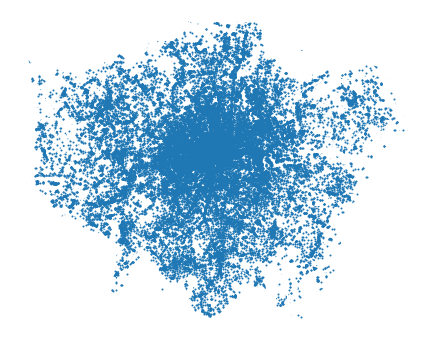

In [5]:
pois.to_crs(epsg=3395).plot(figsize=(8,6), markersize=1)
plt.axis('off');

In [6]:
# Save the data
directory = "data/processed/pois/"
if not os.path.exists(directory):
    print(f'Succefully created new directory {directory}')
    os.makedirs(directory)

# Save complete data
pois.to_csv(directory + "pois.csv", index=False)

## Step 3. Check polygons (statistical boundaries)

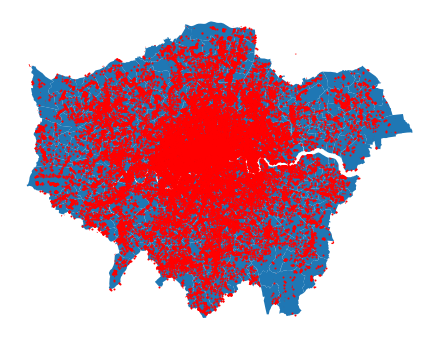

In [7]:
# Load the data
geometry = gpd.read_file('data/raw/geometry/statistical-gis-boundaries-london/ESRI/OA_2011_London_gen_MHW.shp').to_crs(epsg=4326)

# Get wards from the original data set
polygons = geometry.dissolve("WD11CD_BF", aggfunc="sum", as_index=False)

# 
ax = polygons.to_crs(epsg=3395).plot(figsize=(8,6))
pois.to_crs(epsg=3395).plot(figsize=(8,6), markersize=1, color='red', ax=ax)
plt.axis('off');

## Step 4. Convert polygons into a hexgrid 

Now let's convert polygons into hexgrid. For this, we'll use a cool script prepared by [Will Geary](https://twitter.com/wgeary) (the original notebook is [here](https://github.com/willgeary/covid-nyc-dasymetric-map/blob/master/notebook.ipynb)). Note that it requires two additional libraries: [folium](https://python-visualization.github.io/folium/) for visualization of result (can be shut down) and [Ubder's H3](https://github.com/uber/h3-py) for creating the hexgrid (essential). Installation of H3 on Windows machine can be [a bit clumsy](https://www.google.com/search?q=h3+install+windows&oq=h3+install+windows&aqs=chrome..69i57j33.2389j0j7&sourceid=chrome&ie=UTF-8). In my case I've simply installed h3-py from conda-forge. That is, in Anaconda Prompt type (don't forget to switch to a new virtual environment):

```bash
conda install -c conda-forge h3-py
```

I hope it will work for you as well.

In [8]:
from create_hexgrid import create_hexgrid

In [9]:
# Define parameters of a hexgrid
hex_res = 7
buffer = 0.005
plot = False
hex_id = f'hex_id_{hex_res}'

# Create the hexgrid
hexgrid = create_hexgrid(polygons, hex_res=hex_res, buffer=buffer, plot=plot)
hexgrid.reset_index(drop=True, inplace=True)
hexgrid.crs = {'init': 'epsg:4326'}
print(f'Number of polygons: {polygons.shape[0]}')
print(f'Number of hexes: {hexgrid.shape[0]}')

Number of polygons: 632
Number of hexes: 365


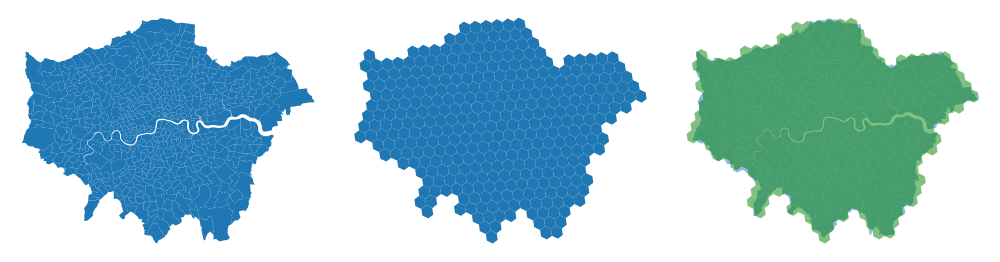

In [10]:
# Let's check the result
fig, ax = plt.subplots(ncols=3, figsize=(14,4))
polygons.to_crs(epsg=3395).plot(ax=ax[0]);
hexgrid.to_crs(epsg=3395).plot(ax=ax[1]);
polygons.to_crs(epsg=3395).plot(ax=ax[2], alpha=.5);
hexgrid.to_crs(epsg=3395).plot(ax=ax[2], alpha=.5, color='green');
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
fig.tight_layout()

## Step 5. Assign POIs and visualize the difference

Now it's time to assgin POIs to districts and hexgrid visualize the difference.

In [11]:
# Load POIs data
pois = pd.read_csv("data/processed/pois/pois.csv", low_memory=False)
pois = gpd.GeoDataFrame(pois, geometry=gpd.points_from_xy(pois['lon'], pois['lat']))
pois.crs = {'init' : 'epsg:4326'}

In [12]:
print(f'We have {pois["poi_type"].unique().shape[0]} unique types of amenities.')

We have 922 unique types of amenities.


In "pois_categorization.csv" we introduced a __subjective categorization__ of POIs into a set of categories. Let's assign these categories to the POIs that we've collected. Note that this categorization must be improved! Otherwise, some POIs will be lost! 

In [13]:
print(f'Number of POIs: {pois.shape[0]}')

# Load categorization and merge it with POIs data
pois_categorization = pd.read_csv("data/external/pois_categorization.csv") 
pois = pd.merge(pois, pois_categorization, left_on='amenity', right_on="pois")
pois.drop('amenity', axis=1, inplace=True)
print(f'Number of POIs left after categorization: {pois.shape[0]}')

Number of POIs: 116466
Number of POIs left after categorization: 82442


In [14]:
# Join POIs and hexgrid
pois_in_hex = gpd.sjoin(pois, hexgrid) 

# Group hexes by pois_category and leave the hex_id as a reference for further plotting
pois_counts = pois_in_hex.groupby(['pois_category', f'{hex_id}']).agg(len)
pois_counts = pois_counts.reset_index()

# Construct a pivot table: columns are hexes, rows are POIs categories
pois_counts = pois_counts.pivot(index="pois_category", columns=f'hex_id_{hex_res}', values= "name")
pois_counts = pois_counts.fillna(0)

# Transpose pivot table to have hexes as rows and categories as columns 
pois_counts = pois_counts.T
pois_counts.head()

C:\Users\Mikhail\AppData\Local\Continuum\miniconda3\envs\heatvuln\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


pois_category,community,culture_and_entertainment,eatery,economic_activity,education,family,misc,mobility,nightlife,public_services,wellbeing
hex_id_7,,,,,,,,,,,
87194ac00ffffff,7.0,0.0,16.0,0.0,0.0,1.0,36.0,2.0,1.0,0.0,3.0
87194ac01ffffff,4.0,0.0,8.0,0.0,0.0,0.0,18.0,0.0,1.0,2.0,5.0
87194ac02ffffff,1.0,0.0,3.0,0.0,0.0,1.0,14.0,1.0,1.0,1.0,2.0
87194ac03ffffff,0.0,0.0,1.0,0.0,0.0,0.0,37.0,1.0,0.0,0.0,0.0
87194ac04ffffff,5.0,0.0,30.0,4.0,1.0,1.0,38.0,10.0,4.0,2.0,12.0


In [15]:
# Merge pivot table with hexgrid for plotting
gdf = pd.merge(hexgrid, pois_counts, right_index=True, left_on=f'hex_id_{hex_res}')

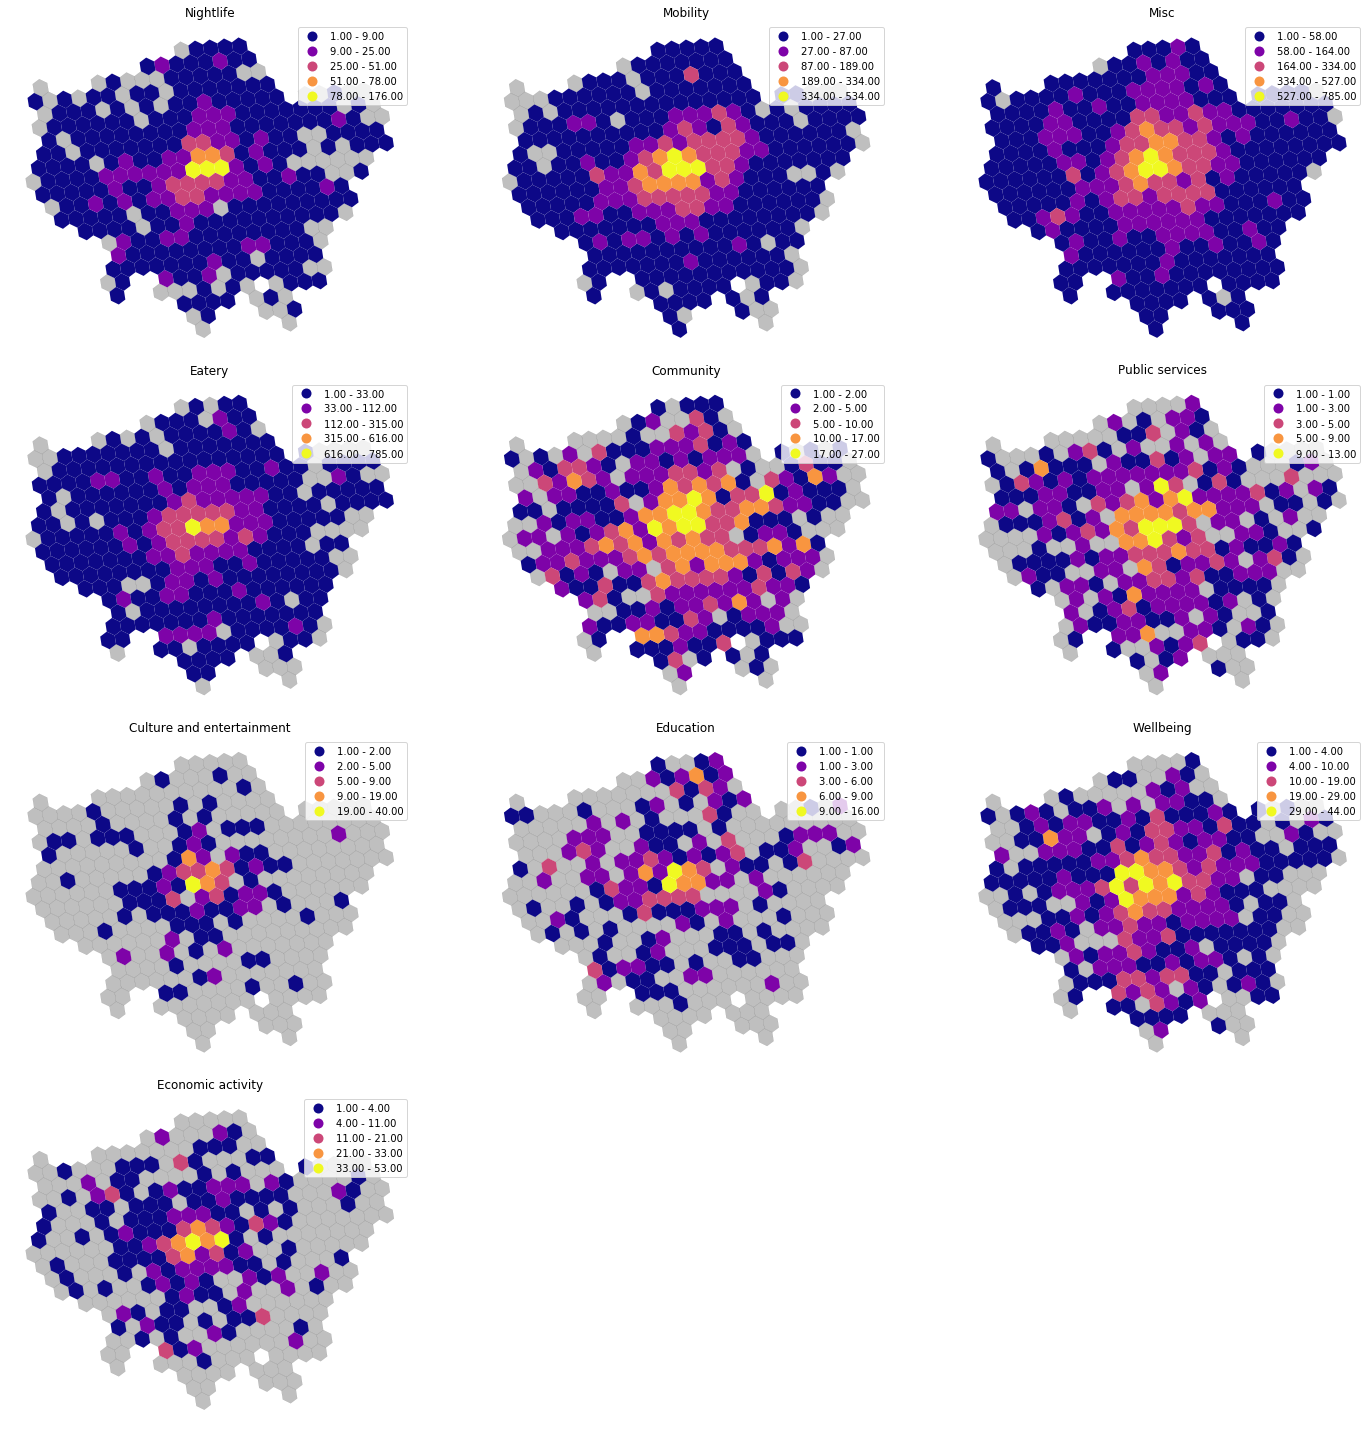

In [16]:
nrows = 4
ncols = 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20), sharex=True)
k = 0
columns = pois['pois_category'].unique().tolist()
for i in range(nrows):
    for j in range(ncols):
        gdf[gdf[columns[k]] == 0].to_crs(epsg=3857).plot(color='gray', alpha=.5, ax=ax[i,j], linewidth=0.1, edgecolor='black')
        gdf[gdf[columns[k]] > 0].to_crs(epsg=3857).plot(column=columns[k], ax=ax[i, j], legend=True, scheme='fisher_jenks', cmap='plasma')
        ax[i, j].set_title(f'{columns[k].capitalize().replace("_", " ")}')
        ax[i, j].axis('off')
        k += 1
        if k == 10:
            break
        
fig.delaxes(ax[3, 1])
fig.delaxes(ax[3, 2])
fig.tight_layout()
plt.savefig('choropleth-hexgrid.png', dpi=300)

In [17]:
# Join POIs and polygons
pois_in_polygons = gpd.sjoin(pois, polygons) 

# Group polygons by pois_category and leave the hex_id as a reference for further plotting
pois_counts = pois_in_polygons.groupby(['pois_category', 'WD11CD_BF']).agg(len)
pois_counts = pois_counts.reset_index()

# Construct a pivot table: columns are polygons, rows are POIs categories 
pois_counts = pois_counts.pivot(index="pois_category", columns='WD11CD_BF', values= "name")
pois_counts = pois_counts.fillna(0)

# Transpose pivot table to have polygon as rows and categories as columns
pois_counts = pois_counts.T 

C:\Users\Mikhail\AppData\Local\Continuum\miniconda3\envs\heatvuln\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'init': 'epsg:4326', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)
C:\Users\Mikhail\AppData\Local\Continuum\miniconda3\envs\heatvuln\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


In [18]:
# Merge pivot table with polygon for plotting
gdf = pd.merge(polygons, pois_counts, right_index=True, left_on='WD11CD_BF')

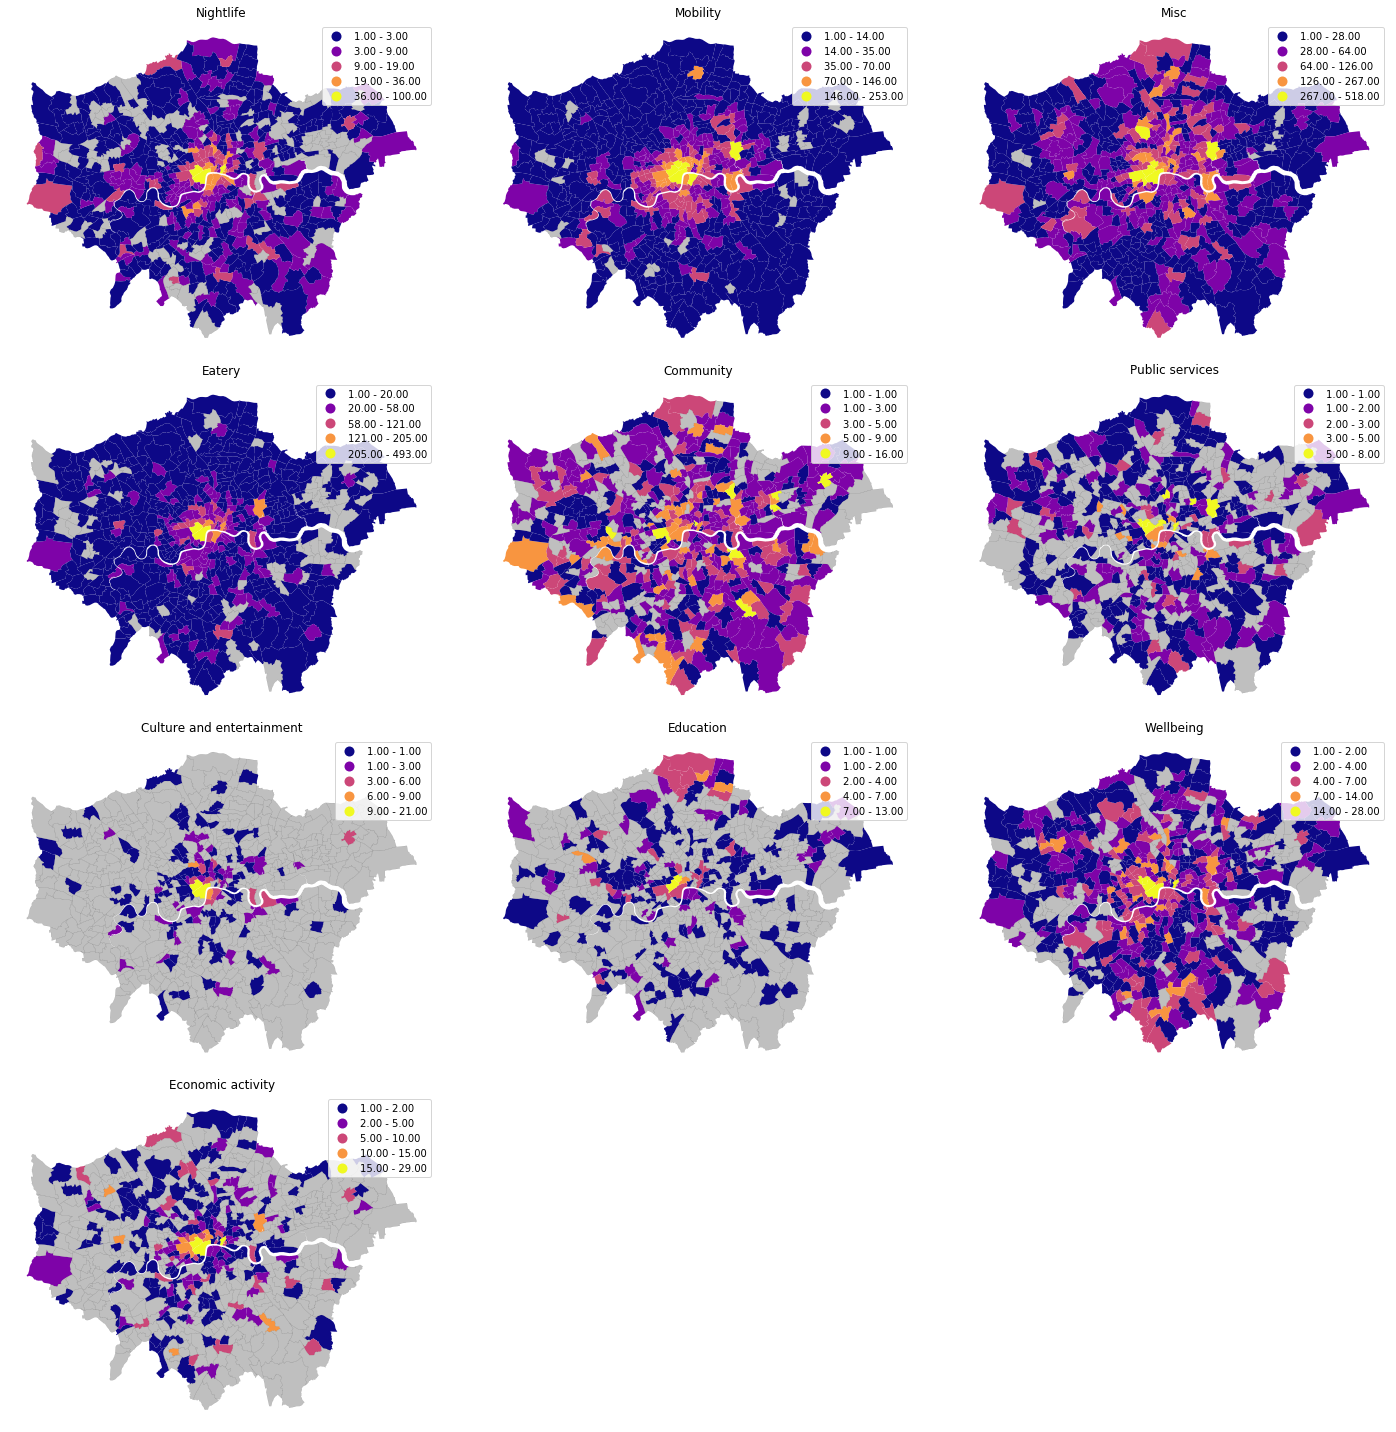

In [21]:
nrows = 4
ncols = 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20), sharex=True)
k = 0
columns = pois['pois_category'].unique().tolist()
for i in range(nrows):
    for j in range(ncols):
        gdf[gdf[columns[k]] > 0].to_crs(epsg=3857).plot(column=columns[k], ax=ax[i, j], legend=True, scheme='fisher_jenks', cmap='plasma')
        gdf[gdf[columns[k]] == 0].to_crs(epsg=3857).plot(color='gray', alpha=.5, ax=ax[i,j], linewidth=0.1, edgecolor='black')
        ax[i, j].set_title(f'{columns[k].capitalize().replace("_", " ")}')
        ax[i, j].axis('off')
        k += 1
        if k == 10:
            break
fig.delaxes(ax[3, 1])
fig.delaxes(ax[3, 2])
fig.tight_layout()
plt.savefig('choropleth-polygon.png', dpi=300)